<h1>Text Classification with Logistic Regression</h1>

In this notebook we are going to go through on how to perform text classification using logistic regression and several text encoding techniques such as bag of words and tf-idf. Our task will be to classify text to determine it's sentiment class. Our dataset contains the movie review data with labeled sentiment class of 0,1,2,3 and 4 where 0 is negative, 1 somehow negative, 2 neutral, 3 somehow positive and 4 positive.<br><br>
We will start with Exploratory Data Analysis then perform machine learning modeling.

##### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk import ngrams
import string,re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import warnings

In [2]:
plt.figure(figsize=(16,7))
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

<Figure size 1152x504 with 0 Axes>

Load data

In [3]:
train=pd.read_csv('datasets/Sentiment Analysis on Movie Reviews/train.tsv',sep='\t')
test=pd.read_csv('datasets/Sentiment Analysis on Movie Reviews/test.tsv',sep='\t')

# Part 1 Exploratory Data Analysis

In [4]:
train.shape, test.shape

((156060, 4), (66292, 3))

In [5]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [6]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
PhraseId      156060 non-null int64
SentenceId    156060 non-null int64
Phrase        156060 non-null object
Sentiment     156060 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [8]:
train.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [9]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


Sentiment Description

In [10]:
train['sentiment_class'] = train['Sentiment'].map({0:'negative',1:'somewhat negative',2:'neutral',3:'somewhat positive',4:'positive'})
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class
0,1,1,A series of escapades demonstrating the adage ...,1,somewhat negative
1,2,1,A series of escapades demonstrating the adage ...,2,neutral
2,3,1,A series,2,neutral
3,4,1,A,2,neutral
4,5,1,series,2,neutral


Remove punctuations

In [11]:
def remove_punctuation(text):
    return "".join([t for t in text if t not in string.punctuation])

In [12]:
train['Phrase']=train['Phrase'].apply(lambda x:remove_punctuation(x))
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class
0,1,1,A series of escapades demonstrating the adage ...,1,somewhat negative
1,2,1,A series of escapades demonstrating the adage ...,2,neutral
2,3,1,A series,2,neutral
3,4,1,A,2,neutral
4,5,1,series,2,neutral


Remove words with less than 2 characters

In [13]:
def words_with_more_than_three_chars(text):
    return " ".join([t for t in text.split() if len(t)>3])

In [14]:
train['Phrase']=train['Phrase'].apply(lambda x:words_with_more_than_three_chars(x))
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class
0,1,1,series escapades demonstrating adage that what...,1,somewhat negative
1,2,1,series escapades demonstrating adage that what...,2,neutral
2,3,1,series,2,neutral
3,4,1,,2,neutral
4,5,1,series,2,neutral


Remove stopwords

In [15]:
stop_words=stopwords.words('english')
train['Phrase']=train['Phrase'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class
0,1,1,series escapades demonstrating adage good goos...,1,somewhat negative
1,2,1,series escapades demonstrating adage good goose,2,neutral
2,3,1,series,2,neutral
3,4,1,,2,neutral
4,5,1,series,2,neutral


check sentiment categories

In [16]:
train.groupby('Sentiment')['Sentiment'].count()

Sentiment
0     7072
1    27273
2    79582
3    32927
4     9206
Name: Sentiment, dtype: int64

Visualize the target variables

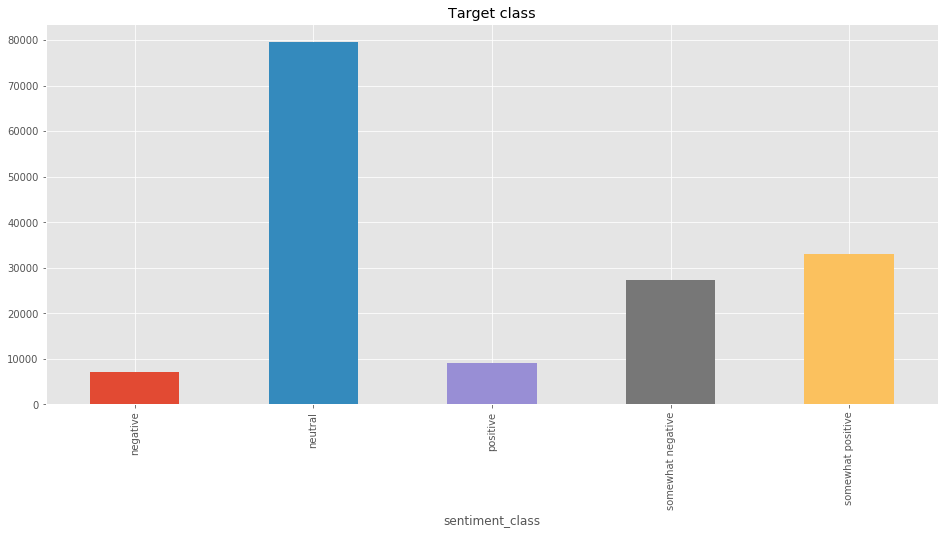

In [17]:
train.groupby('sentiment_class')['sentiment_class'].count().plot(kind='bar',title='Target class',figsize=(16,7),grid=True)

Get percentages of each class

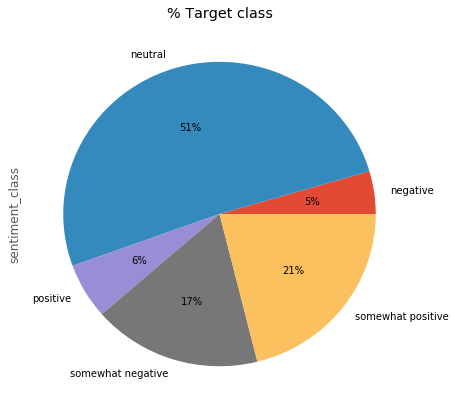

In [18]:
((train.groupby('sentiment_class')['sentiment_class'].count()/train.shape[0])*100).plot(kind='pie',figsize=(7,7),title='% Target class', autopct='%1.0f%%')

Adding Phrase length

In [19]:
train['PhraseLength']=train['Phrase'].apply(lambda x: len(x))

In [20]:
train.sort_values(by='PhraseLength', ascending=False).head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class,PhraseLength
54876,54877,2734,Filmmakers Dana JanklowiczMann Amir Mann area ...,3,somewhat positive,207
62992,62993,3189,addition sporting worst titles recent cinemati...,0,negative,200
26148,26149,1199,movie biggest shocks come seeing former nymphe...,1,somewhat negative,199
62500,62501,3162,While transgressive trappings especially frank...,1,somewhat negative,197
72577,72578,3708,Stephen Earnhart documentary decomposition hea...,1,somewhat negative,196


Distribution of phrase length on each class

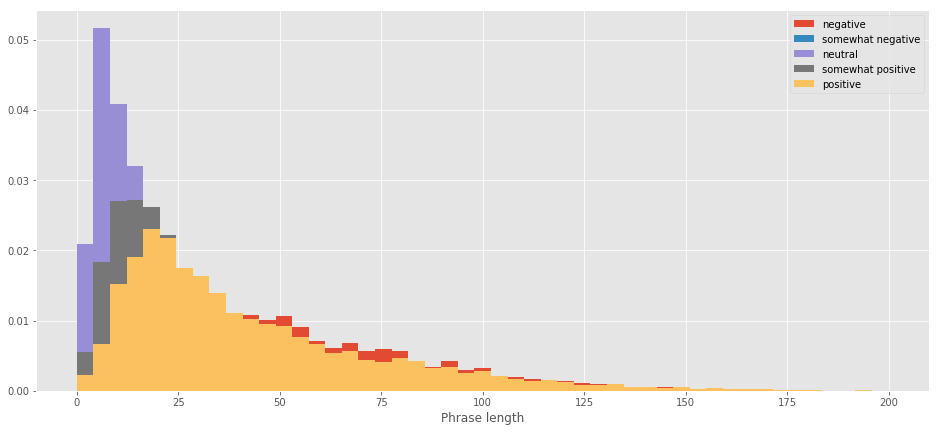

In [21]:
plt.figure(figsize=(16,7))
bins=np.linspace(0,200,50)
plt.hist(train[train['sentiment_class']=='negative']['PhraseLength'],bins=bins,density=True,label='negative')
plt.hist(train[train['sentiment_class']=='somewhat negative']['PhraseLength'],bins=bins,density=True,label='somewhat negative')
plt.hist(train[train['sentiment_class']=='neutral']['PhraseLength'],bins=bins,density=True,label='neutral')
plt.hist(train[train['sentiment_class']=='somewhat positive']['PhraseLength'],bins=bins,density=True,label='somewhat positive')
plt.hist(train[train['sentiment_class']=='positive']['PhraseLength'],bins=bins,density=True,label='positive')
plt.xlabel('Phrase length')
plt.legend()
plt.show()

Common words with word cloud

In [22]:
# Install wordcoud library
# !pip install wordcloud

In [23]:
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS) 

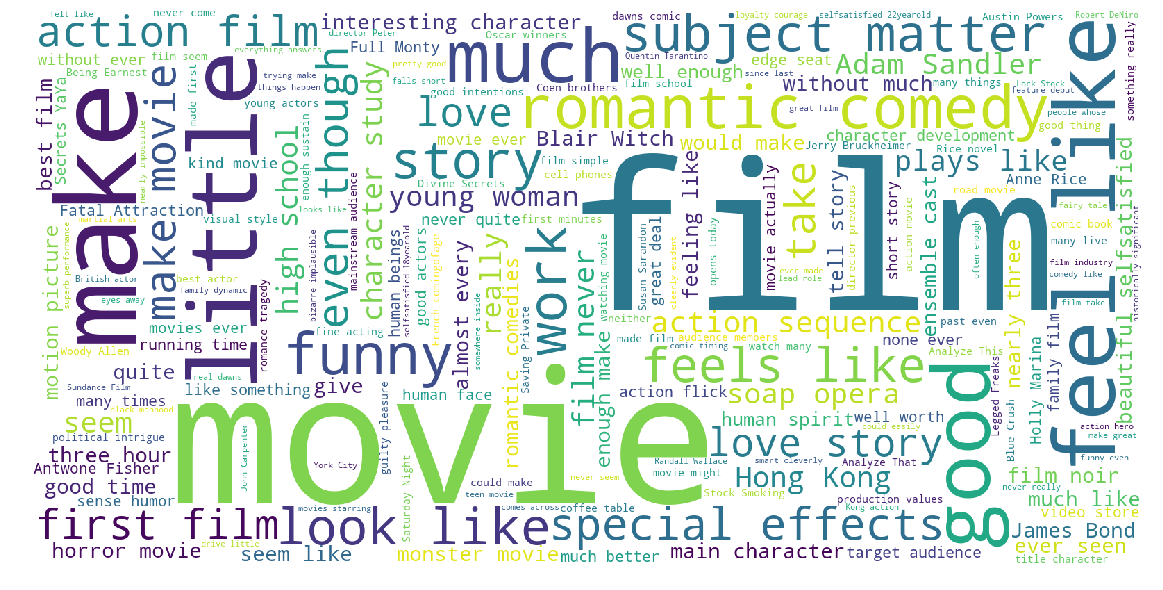

In [24]:
word_cloud_common_words=[]  
for index, row in train.iterrows(): 
    word_cloud_common_words.append((row['Phrase'])) 
word_cloud_common_words

wordcloud = WordCloud(width = 1600, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 5).generate(''.join(word_cloud_common_words)) 
  
# plot the WordCloud image                        
plt.figure(figsize = (16, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Word Frequency

In [25]:
text_list=[]  
for index, row in train.iterrows(): 
    text_list.append((row['Phrase'])) 
text_list

total_words=''.join(text_list)
total_words=word_tokenize(total_words)

In [26]:
freq_words=FreqDist(total_words)
word_frequency=FreqDist(freq_words)

In [27]:
# 10 common words
print(word_frequency.most_common(10))

[('film', 3259), ('movie', 2892), ('like', 1968), ('story', 1204), ('much', 1085), ('good', 1069), ('even', 1041), ('characters', 994), ('little', 976), ('make', 838)]


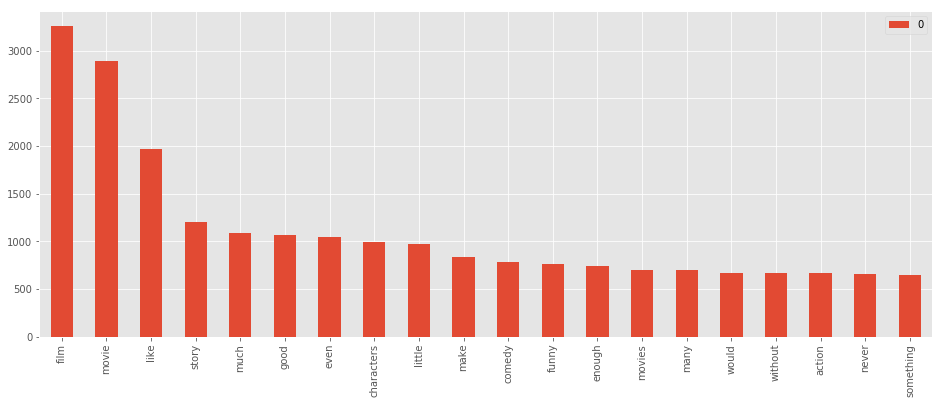

In [28]:
# visualize 
pd.DataFrame(word_frequency,index=[0]).T.sort_values(by=[0],ascending=False).head(20).plot(kind='bar',figsize=(16,6),grid=True)

Common words used for negative sentiment

In [29]:
neg_text_list=[]  
for index, row in train[train['Sentiment']==0].iterrows(): 
    neg_text_list.append((row['Phrase'])) 
neg_text_list

neg_total_words=' '.join(neg_text_list)
neg_total_words=word_tokenize(neg_total_words)

neg_freq_words=FreqDist(neg_total_words)
neg_word_frequency=FreqDist(neg_freq_words)

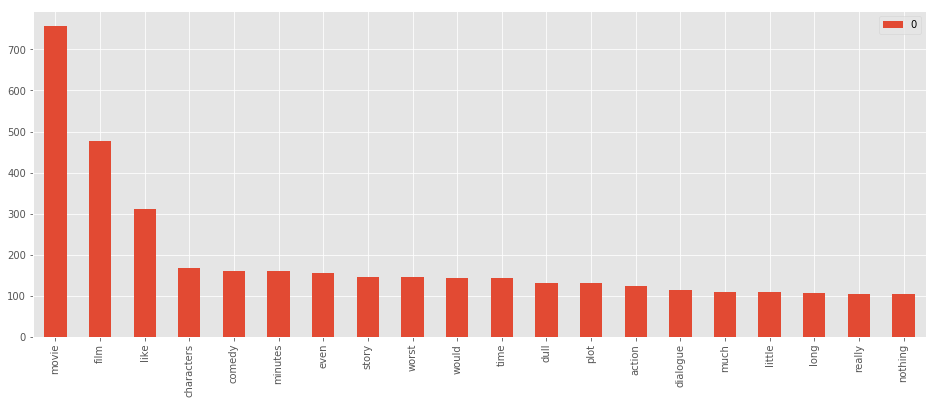

In [30]:
# visualize 
pd.DataFrame(neg_word_frequency,index=[0]).T.sort_values(by=[0],ascending=False).head(20).plot(kind='bar',figsize=(16,6),grid=True)

Common words used for positive sentiment

In [31]:
pos_text_list=[]  
for index, row in train[train['Sentiment']==4].iterrows(): 
    pos_text_list.append((row['Phrase'])) 
pos_text_list

pos_total_words=' '.join(pos_text_list)
pos_total_words=word_tokenize(pos_total_words)

pos_freq_words=FreqDist(pos_total_words)
pos_word_frequency=FreqDist(pos_freq_words)

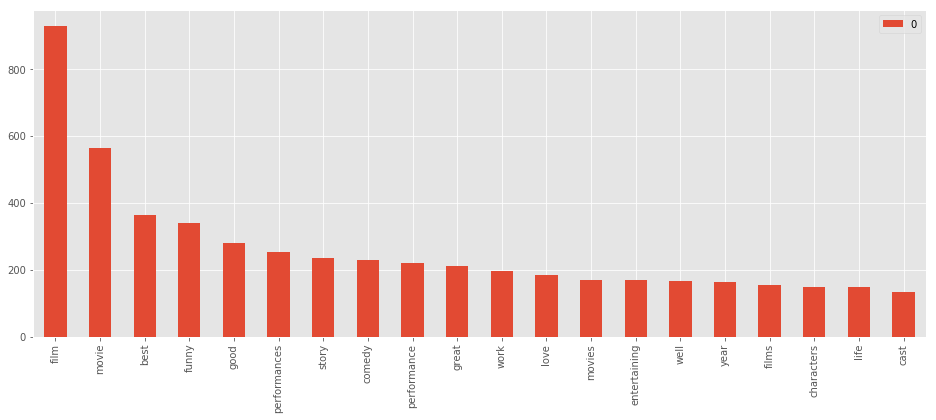

In [32]:
# visualize 
pd.DataFrame(pos_word_frequency,index=[0]).T.sort_values(by=[0],ascending=False).head(20).plot(kind='bar',figsize=(16,6),grid=True)

Common bigram words used for positive sentiment

In [33]:
text="Tom and Jerry love mickey. But mickey dont love Tom and Jerry. What a love mickey is getting from these two friends"
bigram_frequency = FreqDist(ngrams(word_tokenize(text),3))
bigram_frequency.most_common()[0:5]

[(('Tom', 'and', 'Jerry'), 2),
 (('and', 'Jerry', 'love'), 1),
 (('Jerry', 'love', 'mickey'), 1),
 (('love', 'mickey', '.'), 1),
 (('mickey', '.', 'But'), 1)]

In [34]:
text_list=[]  
for index, row in train.iterrows(): 
    text_list.append((row['Phrase'])) 
text_list

total_words=' '.join(text_list)
total_words=word_tokenize(total_words)

freq_words=FreqDist(total_words)
word_frequency=FreqDist(ngrams(freq_words,2))
word_frequency.most_common()[0:5]

[(('series', 'escapades'), 1),
 (('escapades', 'demonstrating'), 1),
 (('demonstrating', 'adage'), 1),
 (('adage', 'good'), 1),
 (('good', 'goose'), 1)]

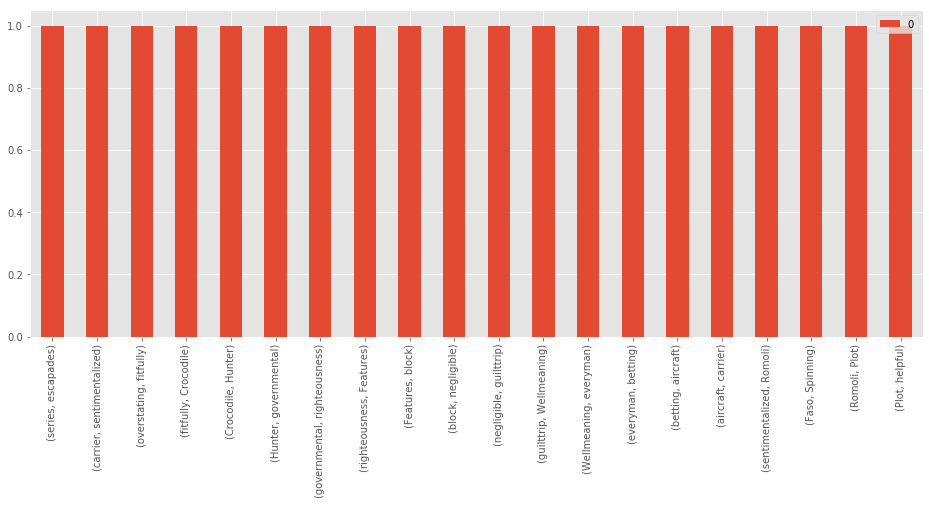

In [35]:
# visualize 
pd.DataFrame(word_frequency,index=[0]).T.sort_values(by=[0],ascending=False).head(20).plot(kind='bar',figsize=(16,6),grid=True)

# Part 2 Machine Learning Modeling

Prepare Training data

Create Bag of words with CountVectorizer

In [36]:
train['tokenized_words']=train['Phrase'].apply(lambda x:word_tokenize(x))
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class,PhraseLength,tokenized_words
0,1,1,series escapades demonstrating adage good goos...,1,somewhat negative,108,"[series, escapades, demonstrating, adage, good..."
1,2,1,series escapades demonstrating adage good goose,2,neutral,47,"[series, escapades, demonstrating, adage, good..."
2,3,1,series,2,neutral,6,[series]
3,4,1,,2,neutral,0,[]
4,5,1,series,2,neutral,6,[series]


In [37]:
count_vectorizer=CountVectorizer(lowercase=True,stop_words='english')
phrase_dtm=count_vectorizer.fit_transform(train['Phrase'])

In [38]:
phrase_dtm.shape

(156060, 15550)

Split data into training and validation sets (70:30) ratio

In [39]:
X_train,X_val,y_train,y_val=train_test_split(phrase_dtm,train['Sentiment'],test_size=0.3, random_state=38)
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((109242, 15550), (109242,), (46818, 15550), (46818,))

Train Logistic Regression model

In [40]:
model=LogisticRegression()

In [41]:
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Measure model performance

In [42]:
accuracy_score(model.predict(X_val),y_val)*100

62.7365543167158

Free up memory for tf-idf

In [43]:
del X_train
del X_val
del y_train
del y_val

Preparing data with tf-idf

In [44]:
tfidf=TfidfVectorizer(lowercase=True,stop_words='english')
tfidf_dtm=tfidf.fit_transform(train['Phrase'])

In [45]:
X_train,X_val,y_train,y_val=train_test_split(tfidf_dtm,train['Sentiment'],test_size=0.3, random_state=38)
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((109242, 15550), (109242,), (46818, 15550), (46818,))

In [46]:
tfidf_model=LogisticRegression(solver='liblinear',max_iter=500, multi_class='ovr',n_jobs=-1)

In [47]:
tfidf_model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [48]:
accuracy_score(tfidf_model.predict(X_val),y_val)*100

61.23713101798454

Predict on test data

In [49]:
print(tfidf_model.predict(X_val)[0:10])

[3 2 2 2 3 2 2 3 2 3]


new data prediction function

In [50]:
def predict_new_text(text):
    tfidf_text=tfidf.transform([text])
    return tfidf_model.predict(tfidf_text)

In [51]:
predict_new_text("The movie is bad and sucks!")

array([0], dtype=int64)

Prepare Test Data

In [52]:
test['Phrase']=test['Phrase'].apply(lambda x:remove_punctuation(x))
test['Phrase']=test['Phrase'].apply(lambda x:words_with_more_than_three_chars(x))
test['Phrase']=test['Phrase'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test_dtm=tfidf.transform(test['Phrase'])

In [53]:
# Predict with test data
test['Sentiment']=tfidf_model.predict(test_dtm)
test.set_index=test['PhraseId']
test.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,intermittently pleasing mostly routine effort,3
1,156062,8545,intermittently pleasing mostly routine effort,3
2,156063,8545,,2
3,156064,8545,intermittently pleasing mostly routine effort,3
4,156065,8545,intermittently pleasing mostly routine,3


In [54]:
# save results to csv file
# test.to_csv('Submission.csv',columns=['PhraseId','Sentiment'],index=False)